In [1]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import seaborn as sns; 
tfd = tf.contrib.distributions

import tensorflow_probability as tfp
tfd = tfp.distributions


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

print(tf.__version__)

W1005 02:11:24.792948 139794871240512 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



1.15.0-rc2


In [12]:
tf.reset_default_graph()


mx = tf.Variable([-5.,0.,0.],name='mx')
low = [mx[0] - 3,mx[1] - 3,mx[2]-1e-6]
high = [mx[0] + 3,mx[1] + 3,mx[2]+1e-6]
p_x = tfd.TruncatedNormal(loc=mx,scale=1.,low=low, high=high)

m = tf.Variable([5.,0., 0],name='m')
low_m = [m[0] - 3, m[1] - 3, m[2]-1e-6]
high_m = [m[0] + 3, m[1] + 3, m[2]+1e-6]
q = tfd.TruncatedNormal(loc=m,scale=1.,low=low_m, high=high_m)

mu_ = tf.Variable([0.,0., 0.])
sigma_ = 1*tf.Variable([6., 1., 1.])
base = tfd.Normal(loc=mu_, scale=sigma_)

samples = base.sample([512]) 
p_samples = p_x.sample([200])
q_samples = q.sample([200])

pd = tf.reduce_mean(tf.square((p_x.prob(q_samples)/q.prob(q_samples)) - 1)) #pearson div
kld = tf.reduce_mean( tf.log(q.prob(q_samples) + 1e-10) - tf.log(p_x.prob(q_samples) + 1e-10) ) #kl div

ratio_p = p_x.prob(samples)/base.prob(samples) 
ratio_q = q.prob(samples)/base.prob(samples)


sbd = tf.reduce_mean( tf.square(ratio_p - 1) - tf.square(ratio_q - 1) - 2*(ratio_q-1)*(ratio_p-ratio_q) )

t_vars = tf.trainable_variables()

opt = tf.train.AdamOptimizer(learning_rate=1e-2)
train = opt.minimize(sbd, var_list=[m])
init = tf.global_variables_initializer()

Tensor("truediv_1:0", shape=(512, 3), dtype=float32)
[<tf.Variable 'mx:0' shape=(3,) dtype=float32_ref>, <tf.Variable 'm:0' shape=(3,) dtype=float32_ref>, <tf.Variable 'Variable:0' shape=(3,) dtype=float32_ref>, <tf.Variable 'Variable_1:0' shape=(3,) dtype=float32_ref>]


7.2167854
3.6864808
[-8.0, -3.0, -1e-06] [-2.0, 3.0, 1e-06]
[2.0, -3.0, -1e-06] [8.0, 3.0, 1e-06]
7.227635
3.317939
[-8.0, -3.0, -1e-06] [-2.0, 3.0, 1e-06]
[-1.9586962, -3.0, -1e-06] [4.0413036, 3.0, 1e-06]
7.107128
3.6213446
[-8.0, -3.0, -1e-06] [-2.0, 3.0, 1e-06]
[-2.8116288, -3.0, -1e-06] [3.1883712, 3.0, 1e-06]
6.9232006
3.021623
[-8.0, -3.0, -1e-06] [-2.0, 3.0, 1e-06]
[-3.5907307, -3.0, -1e-06] [2.4092693, 3.0, 1e-06]
-2.9802322e-10
-1.326466e-10
[-8.0, -3.0, -1e-06] [-2.0, 3.0, 1e-06]
[-8.0, -3.0, -1e-06] [-2.0000005, 3.0, 1e-06]
-9.536743e-09
-1.2909472e-08
[-8.0, -3.0, -1e-06] [-2.0, 3.0, 1e-06]
[-8.0, -3.0, -1e-06] [-2.0000005, 3.0, 1e-06]
4.7683715e-09
-6.5063204e-09
[-8.0, -3.0, -1e-06] [-2.0, 3.0, 1e-06]
[-8.0, -3.0, -1e-06] [-2.0000005, 3.0, 1e-06]
1.9967556e-08
9.822027e-09
[-8.0, -3.0, -1e-06] [-2.0, 3.0, 1e-06]
[-8.0, -3.0, -1e-06] [-2.0000005, 3.0, 1e-06]
0.0
0.0
[-8.0, -3.0, -1e-06] [-2.0, 3.0, 1e-06]
[-8.0, -3.0, -1e-06] [-2.0, 3.0, 1e-06]
0.0
0.0
[-8.0, -3.0, -1e-06

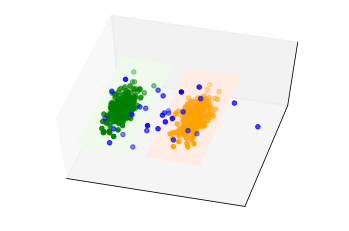

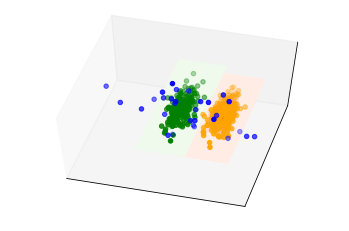

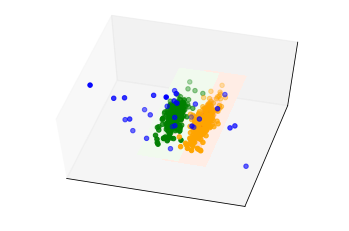

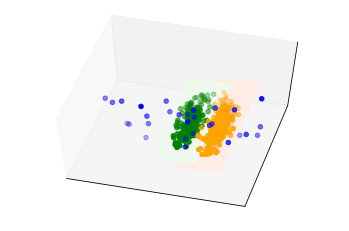

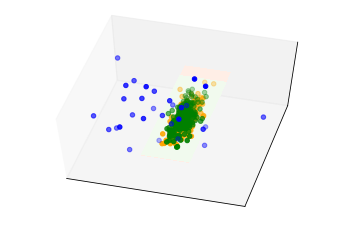

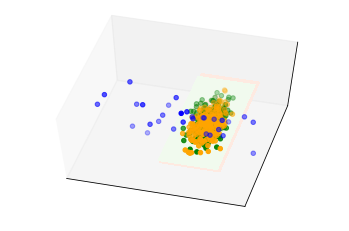

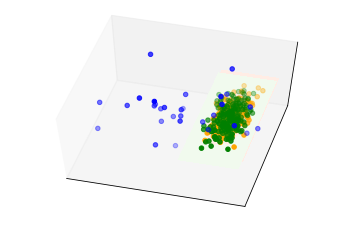

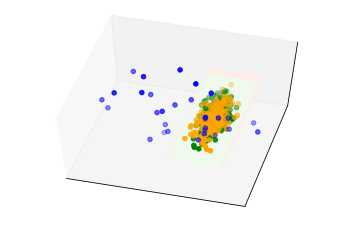

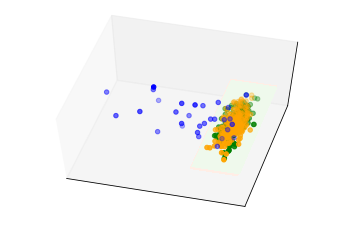

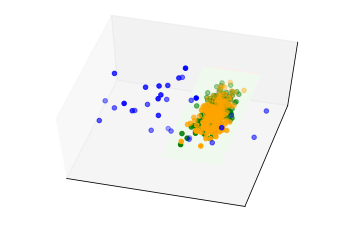

In [13]:
batch_s = 200
batch_sample = 200

# Start Training
# Start a new TF session
sess = tf.Session()

# Run the initializer
sess.run(init)

# Training
kld_store=[]
pd_store=[]
sbd_store=[]
for i in range(0, 10000):
    
    m_,sig1_,m__,sig__ = sess.run([low,high,low_m,high_m])
    # Train
    feed_dict = {}
    kl, pd_, sbd_, p_s,q_s,s,_ = sess.run([kld, pd, sbd, p_samples,q_samples, samples,train],feed_dict=feed_dict)
    kld_store.append(kl)
    pd_store.append(pd_)
    sbd_store.append(sbd_)
    
    if i%1000==0:
        
        fig = plt.figure()        
        ax = fig.add_subplot(111, projection='3d')

        ax.scatter(p_s[:200,0],p_s[:200,1],p_s[:200,2],color='orange')
        ax.scatter(q_s[:200,0],q_s[:200,1],q_s[:200,2],color='green')

        ax.scatter(s[:30,0],s[:30,1],s[:30,2],color='blue') 
        
        sns.kdeplot(p_s[:,0],p_s[:,1],cmap="Reds", shade=True, shade_lowest=False,ax=ax)
        sns.kdeplot(q_s[:,0],q_s[:,1],cmap="Greens", shade=True, shade_lowest=False,ax=ax)

        ax.view_init(-120, 75)
        
        ax.set_xticks(range(-10,11,4)) 
        ax.set_yticks(range(-3,6,2)) 
        ax.set_zticks([1,0])
        
        Add the labels
        ax.set_xlabel('X' )
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.grid(True)

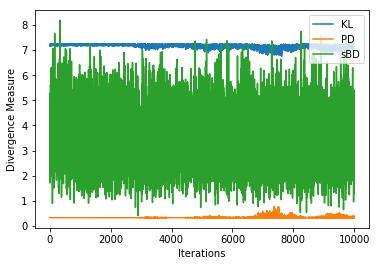

In [4]:
plt.plot(kld_store10[:],label='KL')
plt.plot(pd_store10[:],label='PD')
plt.plot(sbd_store10[:],label='sBD')
plt.xlabel("Iterations")
plt.ylabel("Divergence Measure")
plt.legend(loc='upper right')

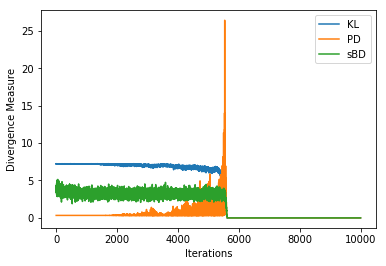

In [178]:
plt.plot(kld_store5[:],label='KL')
plt.plot(pd_store5[:],label='PD')
plt.plot(sbd_store5[:],label='sBD')
plt.xlabel("Iterations")
plt.ylabel("Divergence Measure")
plt.legend(loc='upper right')

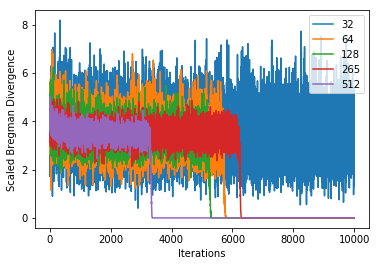

In [14]:
plt.plot(sbd_store10[:],label='32')
plt.plot(sbd_store[:],label='64')
plt.plot(sbd_store5[:],label='128')
plt.plot(sbd_store6[:],label='265')
plt.plot(sbd_store7[:],label='512')
plt.xlabel("Iterations")
plt.ylabel("Scaled Bregman Divergence")
plt.legend(loc='upper right')